<a href="https://colab.research.google.com/github/Afarisphi/ML-for-Stock/blob/main/ML_Stock%20Trading%20Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the necessary libaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import math
import numpy as np
from termcolor import colored as cl

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 8)

## Getting data from IEX cloud

In [2]:
import requests

iex_api_key = 'pk_43802bf066b94613b17ac83b7938cf9b'
api_url = f'https://api.iex.cloud/v1/data/core/historical_prices/aapl?range=5d&token={iex_api_key}'

data = requests.get(api_url).json()
print(data)


[{'close': 176.55, 'fclose': 176.55, 'fhigh': 178.35, 'flow': 174.21, 'fopen': 174.25, 'fvolume': 29537314, 'high': 178.35, 'low': 174.21, 'open': 174.25, 'priceDate': '2024-04-12', 'symbol': 'AAPL', 'uclose': 176.55, 'uhigh': 178.35, 'ulow': 174.21, 'uopen': 174.25, 'uvolume': 29537314, 'volume': 29537314, 'id': 'HISTORICAL_PRICES', 'key': 'AAPL', 'subkey': '', 'date': 1712880000000, 'updated': 1713043087312.622}, {'close': 175.04, 'fclose': 175.04, 'fhigh': 175.45, 'flow': 168.17, 'fopen': 168.25, 'fvolume': 28440589, 'high': 175.45, 'low': 168.17, 'open': 168.25, 'priceDate': '2024-04-11', 'symbol': 'AAPL', 'uclose': 175.04, 'uhigh': 175.45, 'ulow': 168.17, 'uopen': 168.25, 'uvolume': 28440589, 'volume': 28440589, 'id': 'HISTORICAL_PRICES', 'key': 'AAPL', 'subkey': '', 'date': 1712793600000, 'updated': 1713043087312.622}, {'close': 167.78, 'fclose': 167.78, 'fhigh': 169.08, 'flow': 167.12, 'fopen': 168.85, 'fvolume': 15529460, 'high': 169.08, 'low': 167.12, 'open': 168.85, 'priceDat

In [3]:
import pandas as pd
import requests

def get_historic_data(symbol):
    ticker = symbol
    iex_api_key = 'pk_43802bf066b94613b17ac83b7938cf9b'
    api_url = f'https://api.iex.cloud/v1/data/core/historical_prices/{ticker}?range=1y&token={iex_api_key}'
    df = requests.get(api_url).json()

    date = []
    open = []
    high = []
    low = []
    close = []

    for i in range(len(df)):
        date.append(pd.to_datetime(df[i]['date'], unit='ms'))  # Convert milliseconds to datetime
        open.append(df[i]['open'])
        high.append(df[i]['high'])
        low.append(df[i]['low'])
        close.append(df[i]['close'])

    data = {
        'date': date,
        'open': open,
        'high': high,
        'low': low,
        'close': close
    }

    df = pd.DataFrame(data)
    return df

msft = get_historic_data('MSFT')
msft = msft.set_index('date')
msft = msft[msft.index >= '2024-01-01']

msft.to_csv('msft.csv')
msft = pd.read_csv('msft.csv').set_index('date')
msft.index = pd.to_datetime(msft.index)
msft.tail()


,open,high,low,close
date,,,,
2024-01-08,369.30,375.20,369.01,374.69
2024-01-05,369.04,372.05,366.50,367.75
2024-01-04,370.83,373.10,367.18,367.94
2024-01-03,369.15,373.25,368.54,370.60
2024-01-02,373.69,375.90,366.80,370.87


## Calculating SMA

In [4]:
def sma(data, n):
    sma = data.rolling(window=n, min_periods=1).mean()
    return pd.DataFrame(sma)

n = [5, 8, 13]
for i in n:
    msft[f'sma_{i}'] = sma(msft['close'], i)

msft.tail()


,open,high,low,close,sma_5,sma_8,sma_13
date,,,,,,,
2024-01-08,369.30,375.20,369.01,374.69,381.270,384.99500,390.882308
2024-01-05,369.04,372.05,366.50,367.75,377.126,381.73000,388.026923
2024-01-04,370.83,373.10,367.18,367.94,373.788,379.03875,385.363846
2024-01-03,369.15,373.25,368.54,370.60,371.354,376.58000,383.186923
2024-01-02,373.69,375.90,366.80,370.87,370.370,374.38000,381.214615


## Plotting the SMA Values


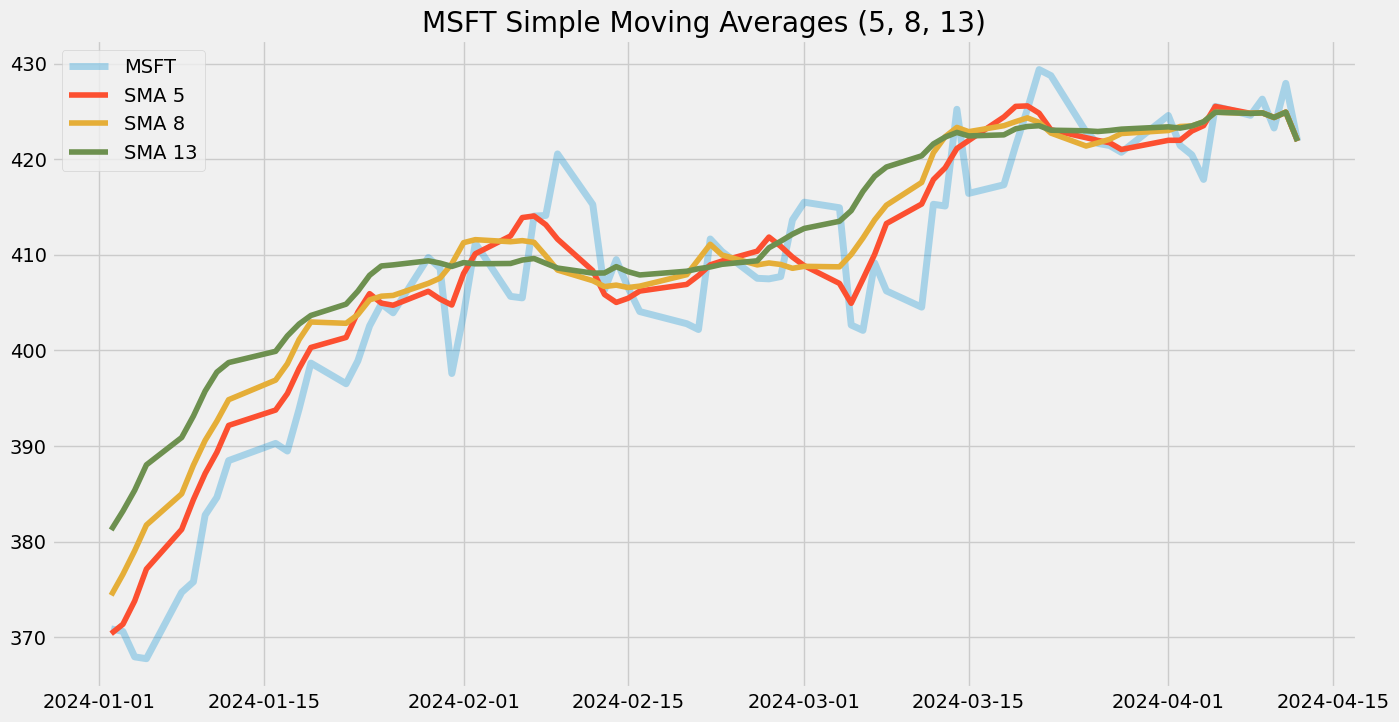

In [5]:
plt.plot(msft['close'], label = 'MSFT', linewidth = 5, alpha = 0.3)
plt.plot(msft['sma_5'], label = 'SMA 5')
plt.plot(msft['sma_8'], label = 'SMA 8')
plt.plot(msft['sma_13'], label = 'SMA 13')
plt.title('MSFT Simple Moving Averages (5, 8, 13)')
plt.legend(loc = 'upper left')
plt.show()

## Creating a Trading Strategy


In [6]:
def implement_sma_strategy(data, smas):
    short_window = smas[0]
    long_window = smas[1]
    buy_price = []
    sell_price = []
    sma_signal = []
    signal = 0

    for i in range(len(data)):
        if short_window[i] > long_window[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                sma_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                sma_signal.append(0)
        elif long_window[i] > short_window[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                sma_signal.append(-1)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                sma_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            sma_signal.append(0)

    return buy_price, sell_price, sma_signal


sma_5 = msft['sma_5']
sma_8 = msft['sma_8']
sma_13 = msft['sma_13']

buy_price, sell_price, signal = implement_sma_strategy(msft['close'], [sma_5, sma_8, sma_13])

## Plotting the Trading lists


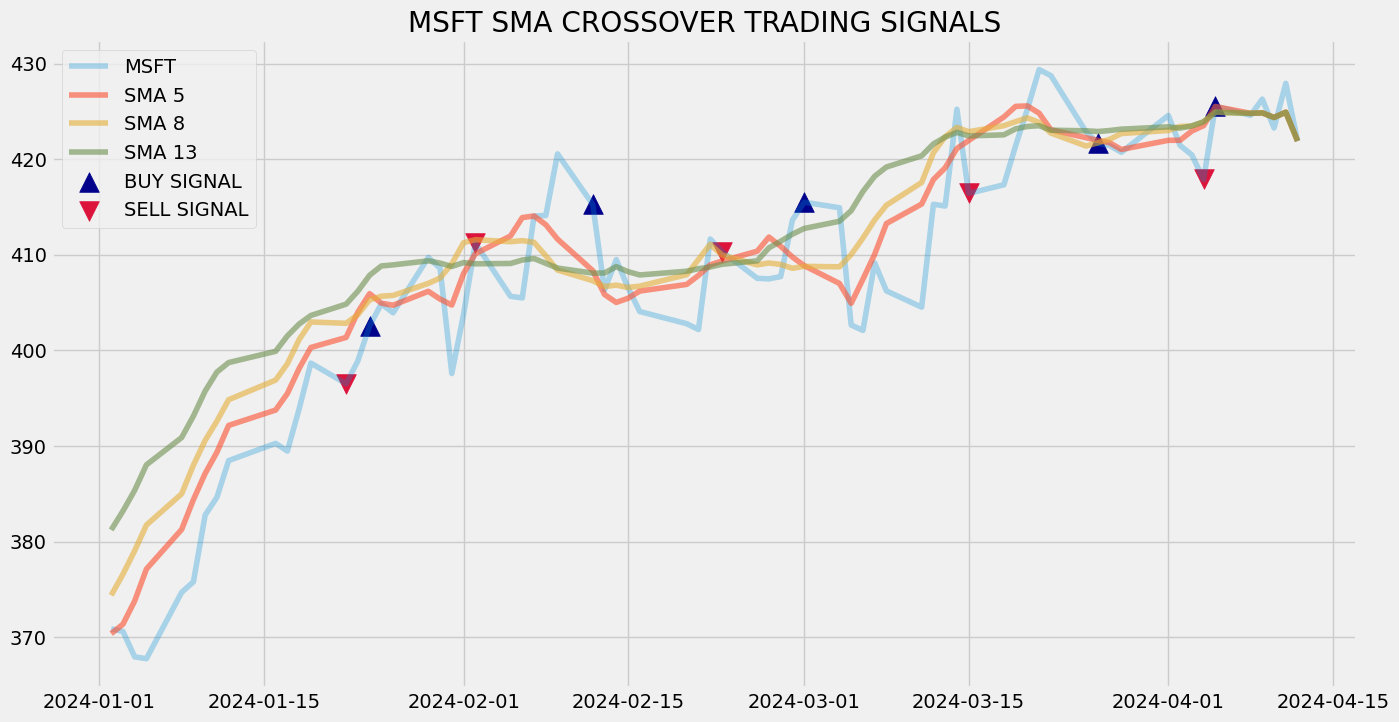

In [7]:
plt.plot(msft['close'], alpha = 0.3, label = 'MSFT')
plt.plot(sma_5, alpha = 0.6, label = 'SMA 5')
plt.plot(sma_8, alpha = 0.6, label = 'SMA 8')
plt.plot(sma_13, alpha = 0.6, label = 'SMA 13')
plt.scatter(msft.index, buy_price, marker = '^', s = 200, color = 'darkblue', label = 'BUY SIGNAL')
plt.scatter(msft.index, sell_price, marker = 'v', s = 200, color = 'crimson', label = 'SELL SIGNAL')
plt.legend(loc = 'upper left')
plt.title('MSFT SMA CROSSOVER TRADING SIGNALS')
plt.show()

## Creating our Position


In [8]:
position = []
for i in range(len(signal)):
    if signal[i] > 1:
        position.append(0)
    else:
        position.append(1)

for i in range(len(msft['close'])):
    if signal[i] == 1:
        position[i] = 1
    elif signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]

sma_5 = pd.DataFrame(sma_5).rename(columns = {0:'sma_5'})
sma_8 = pd.DataFrame(sma_8).rename(columns = {0:'sma_8'})
sma_13 = pd.DataFrame(sma_13).rename(columns = {0:'sma_13'})
signal = pd.DataFrame(signal).rename(columns = {0:'sma_signal'}).set_index(msft.index)
position = pd.DataFrame(position).rename(columns = {0:'sma_position'}).set_index(msft.index)

frames = [sma_5, sma_8, sma_13, signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index().drop('date', axis = 1)

strategy

,sma_5,sma_8,sma_13,sma_signal,sma_position
0,421.900000,421.900000,421.900000,0,1
1,424.915000,424.915000,424.915000,0,1
2,424.363333,424.363333,424.363333,0,1
3,424.842500,424.842500,424.842500,0,1
4,424.792000,424.792000,424.792000,0,1
...,...,...,...,...,...
66,381.270000,384.995000,390.882308,0,0
67,377.126000,381.730000,388.026923,0,0
68,373.788000,379.038750,385.363846,0,0
69,371.354000,376.580000,383.186923,0,0


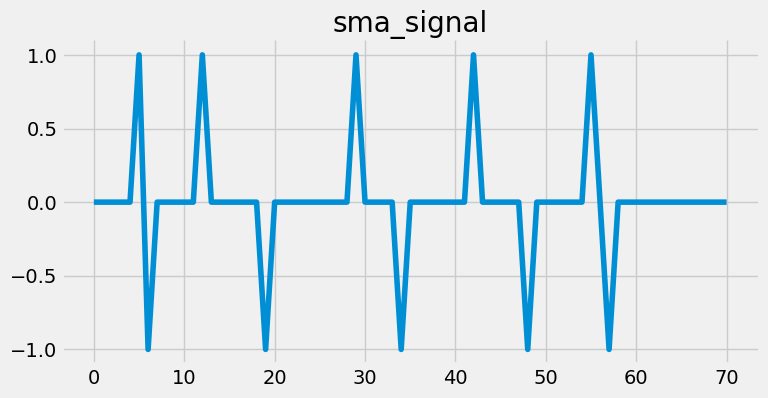

In [9]:
# @title sma_signal

from matplotlib import pyplot as plt
strategy['sma_signal'].plot(kind='line', figsize=(8, 4), title='sma_signal')
plt.gca().spines[['top', 'right']].set_visible(False)

## Backtesting the strategy

In [10]:
msft_ret = pd.DataFrame(np.diff(msft['close'])).rename(columns = {0:'returns'})
sma_strategy_ret = []

for i in range(len(msft_ret)):
    try:
        returns = msft_ret['returns'][i]*strategy['sma_position'][i]
        sma_strategy_ret.append(returns)
    except:
        pass

sma_strategy_ret_df = pd.DataFrame(sma_strategy_ret).rename(columns = {0:'sma_returns'})

investment_value = 10000
number_of_stocks = math.floor(investment_value/msft['close'][1])
sma_investment_ret = []

for i in range(len(sma_strategy_ret_df['sma_returns'])):
    returns = number_of_stocks*sma_strategy_ret_df['sma_returns'][i]
    sma_investment_ret.append(returns)

sma_investment_ret_df = pd.DataFrame(sma_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(sma_investment_ret_df['investment_returns']), 2)
print(cl('Profit gained from the strategy by investing $10000 in Microsoft share : ${} in 1 Year'.format(total_investment_ret), attrs = ['bold']))


Profit gained from the strategy by investing $10000 in Microsoft share : $-563.5 in 1 Year
